In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", None)

In [2]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, classification_report

# Read in the Data

In [3]:
full_df = pd.read_pickle("full_clean_df.pkl")
full_df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education',
       'household_adults', 'household_children', 'h1n1_vaccine',
       'seasonal_vaccine', 'health_insurance_0.0', 'health_insurance_1.0',
       'health_insurance_nan', 'doctor_recc_h1n1_0.0', 'doctor_recc_h1n1_1.0',
       'doctor_recc_h1n1_nan', 'doctor_recc_seasonal_0.0',
       'doctor_recc_seasonal_1.0', 'doctor_recc_seasonal_nan',
       'income_poverty_<= $75,000, Above Poverty', 'income_poverty_> $75,000',
       'income_poverty_

In [4]:
# full_df.to_csv('full_clean_df.csv')

In [5]:
all_resp = full_df.shape[0]
all_resp

24280

In [6]:
sum(full_df['h1n1_knowledge']==3.0)

0

### Lets look at the target breakdowns

In [7]:
h1n1_target = full_df["h1n1_vaccine"]
seasonal_target = full_df["seasonal_vaccine"]

/Users/ryanwerth/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/ryanwerth/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/ryanwerth/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/ryanwerth/

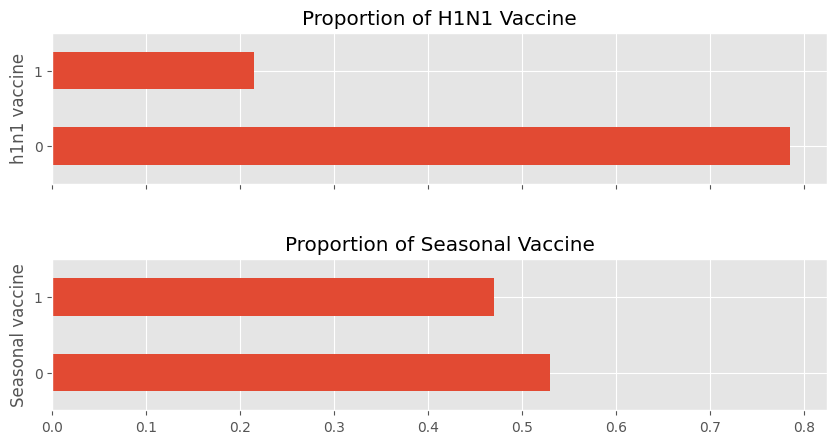

In [8]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 5), dpi=100)
fig
plt.subplots_adjust(hspace=.5)

h1n1_target.value_counts().div(all_resp).plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])

ax[0].set_ylabel("h1n1 vaccine")

seasonal_target.value_counts().div(all_resp).plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])

ax[1].set_ylabel("Seasonal vaccine")

plt.savefig('unbalanced_bar.png');

### Seasonal is balanced, h1n1 is imbalanced. Ok Ok. Lets see how correlated our two target variables are.

In [9]:
pd.crosstab(
    h1n1_target, 
    seasonal_target, 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.493822,0.291763,0.785585
1,0.035914,0.178501,0.214415
All,0.529736,0.470264,1.000000


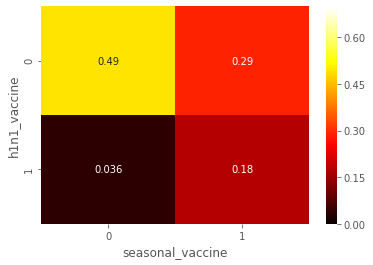

In [10]:
sns.heatmap(pd.crosstab(
    h1n1_target, 
    seasonal_target,
    normalize=True),
            annot=True,
            cmap="hot",
            vmin = 0,
            vmax=.7
    
);

There is a minor correlation. If you got seasonal you had a higher chance of getting h1n1. If you didnt get Seasonal you were MUCH more likely to not get h1n1.

# Lets look at just h1n1

In [11]:
health_insurance = ['health_insurance_0.0', 'health_insurance_1.0', 'health_insurance_nan']
full_df[health_insurance]

,health_insurance_0.0,health_insurance_1.0,health_insurance_nan
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
26701,0,1,0
26702,0,0,1
26703,0,1,0
26704,0,0,1


In [12]:
yes_health_ins = full_df[full_df['health_insurance_1.0'] == 1]["h1n1_vaccine"].value_counts()
no_health_ins = full_df[full_df['health_insurance_0.0'] == 1]["h1n1_vaccine"].value_counts()
na_health_ins = full_df[full_df['health_insurance_nan'] == 1]["h1n1_vaccine"].value_counts()

In [13]:
yes_health_ins

0    8236
1    3848
Name: h1n1_vaccine, dtype: int64

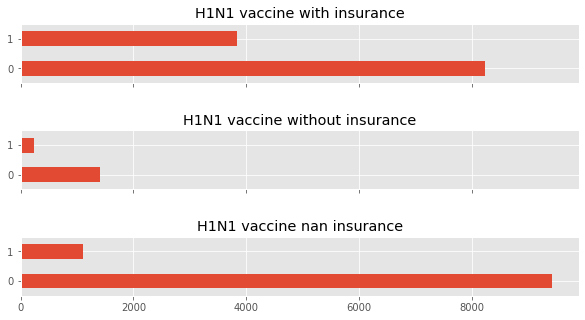

In [14]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
fig
plt.subplots_adjust(hspace=.8)

yes_health_ins.plot.barh(title="H1N1 vaccine with insurance", ax=ax[0])


no_health_ins.plot.barh(title="H1N1 vaccine without insurance", ax=ax[1])


na_health_ins.plot.barh(title="H1N1 vaccine nan insurance", ax=ax[2]);

The nan for health insurance is weird, almost no one reported no health insurance, but a lot have nan. However, health insurance is a big indicator if if someone got the vaccine


### lets look at more relationships

In [15]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (full_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

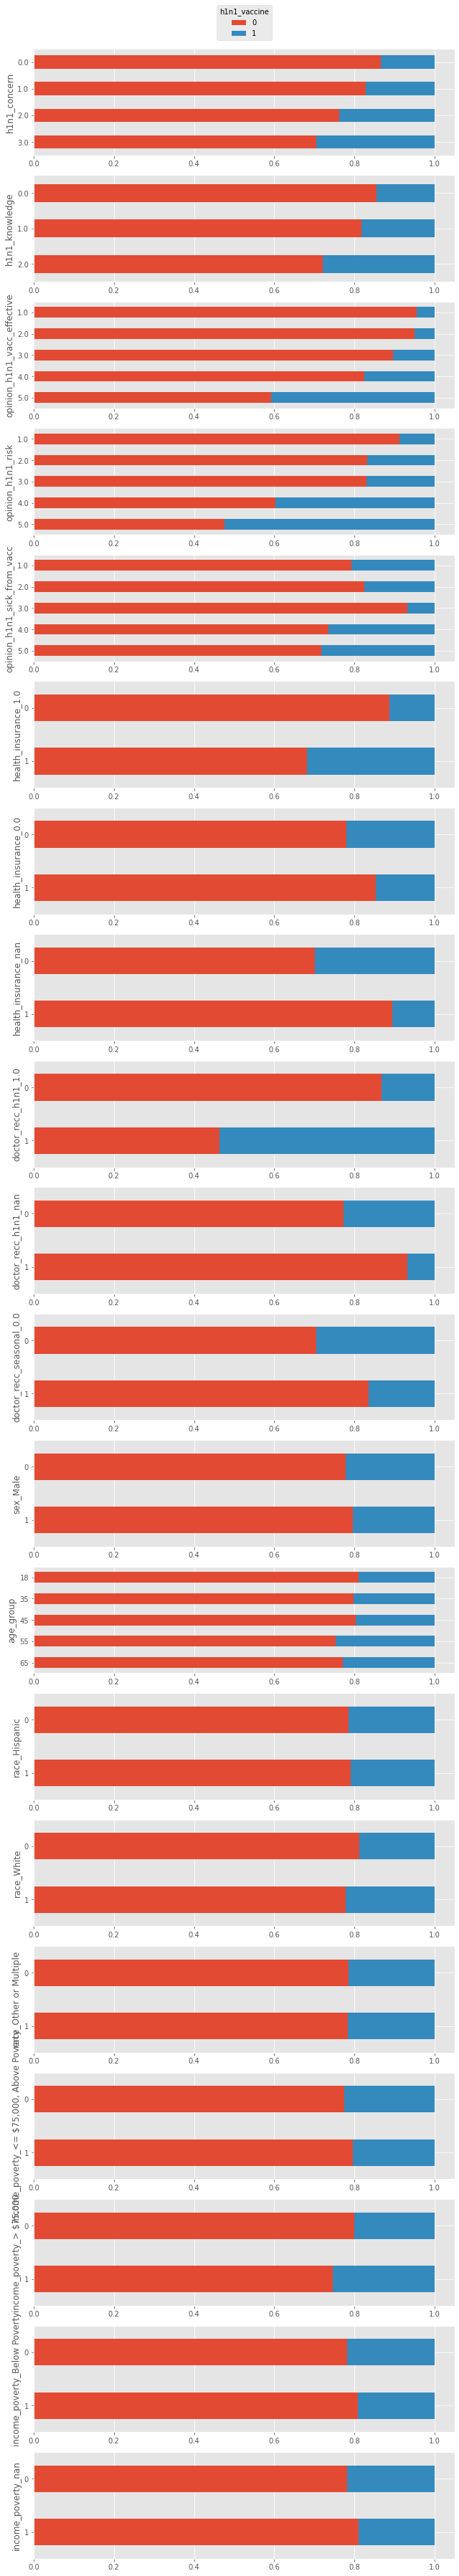

In [16]:

cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'health_insurance_1.0',
    'health_insurance_0.0',
    'health_insurance_nan',
    'doctor_recc_h1n1_1.0',
    'doctor_recc_h1n1_nan', 
    'doctor_recc_seasonal_0.0',
    'sex_Male',
    'age_group',
    'race_Hispanic',
    'race_White',
    'race_Other or Multiple',
    'income_poverty_<= $75,000, Above Poverty', 
    'income_poverty_> $75,000',
    'income_poverty_Below Poverty', 
    'income_poverty_nan',
    
]

fig, ax = plt.subplots(
    len(cols_to_plot), 1, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', full_df, ax=ax[idx]
    )
    
ax[0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
fig.tight_layout()

concern, knowledge, affectiveness, risk, doctor rec, and health ins are all major factors. Race, age group, gender, income dont seem to factor that much

# split data for models

Lets start exploring different models

In [17]:
# remove the holdeout
full_df, ho_df = train_test_split(
    full_df,
    test_size=0.2,
    shuffle=True,
    random_state=100
)

In [18]:
important_features = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
            'opinion_h1n1_sick_from_vacc','health_insurance_1.0', 'health_insurance_0.0', 'health_insurance_nan', 
            'doctor_recc_h1n1_1.0', 'doctor_recc_h1n1_nan', 'doctor_recc_seasonal_0.0',]

features_df = full_df.drop(labels=['h1n1_vaccine', 'seasonal_vaccine'], axis = 1)
h1n1_target = full_df['h1n1_vaccine']
seasonal_target = full_df['seasonal_vaccine']

# Logistic Regression

In [19]:
logistic_regression_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('estimator', LogisticRegression(penalty="l2", C=1))
])

In [20]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
)

In [21]:
logistic_regression_steps.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('estimator', LogisticRegression(C=1))])

In [22]:
# prediction for logistic regression
preds = logistic_regression_steps.predict_proba(X_eval)
preds[:, 1]

array([0.7826453 , 0.08639455, 0.10661484, ..., 0.03040785, 0.01092107,
       0.12405892])

In [23]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

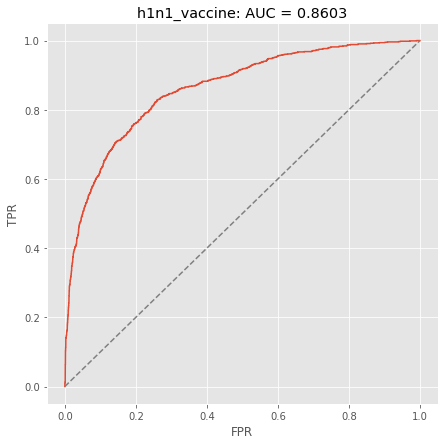

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval, 
    preds[:, 1], 
    'h1n1_vaccine',
    ax=ax
)

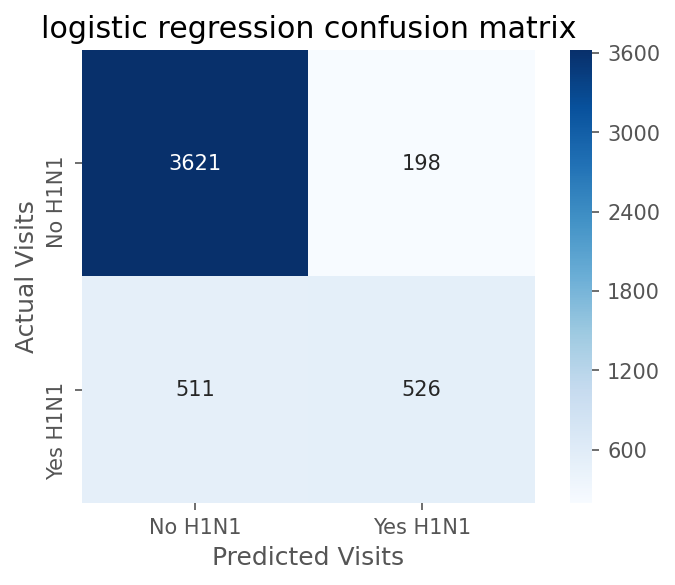

In [25]:
knn_confusion = confusion_matrix(y_eval, logistic_regression_steps.predict(X_eval))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
           xticklabels=['No H1N1', 'Yes H1N1'],
           yticklabels=['No H1N1', 'Yes H1N1'])

plt.xlabel('Predicted Visits')
plt.ylabel('Actual Visits')
plt.title('logistic regression confusion matrix');

In [26]:
print(classification_report(y_eval, logistic_regression_steps.predict(X_eval), target_names=["No H1N1", "Yes H1N1"]))

              precision    recall  f1-score   support

     No H1N1       0.88      0.95      0.91      3819
    Yes H1N1       0.73      0.51      0.60      1037

    accuracy                           0.85      4856
   macro avg       0.80      0.73      0.75      4856
weighted avg       0.84      0.85      0.84      4856



### Seasonal

In [27]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
)

In [28]:
logistic_regression_steps.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('estimator', LogisticRegression(C=1))])

In [29]:
# prediction for logistic regression
preds = logistic_regression_steps.predict_proba(X_eval)
preds[:, 1]

array([0.13185122, 0.33412099, 0.4525346 , ..., 0.55422139, 0.15682606,
       0.11350003])

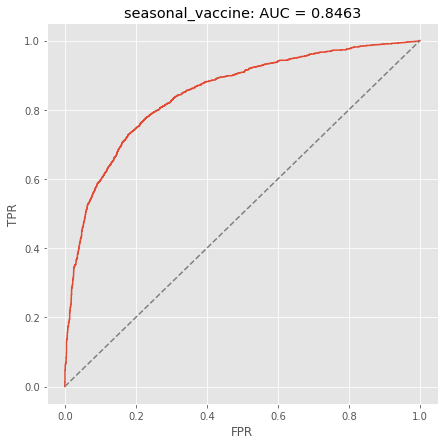

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval, 
    preds[:, 1], 
    'seasonal_vaccine',
    ax=ax
)

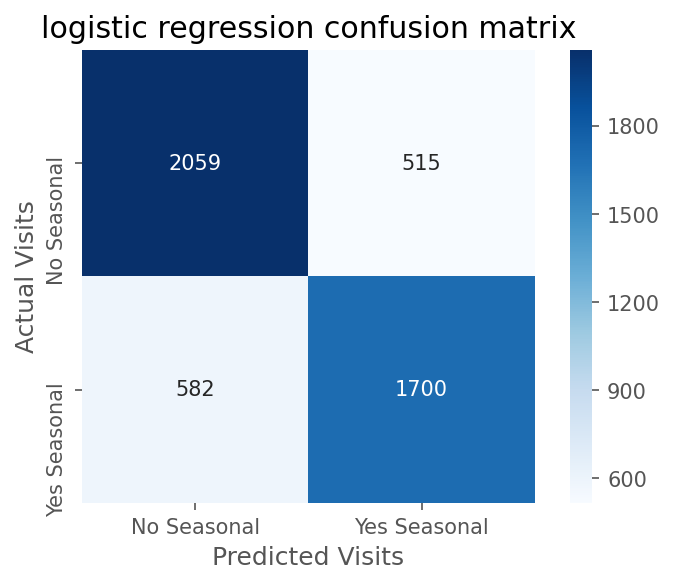

In [31]:
knn_confusion = confusion_matrix(y_eval, logistic_regression_steps.predict(X_eval))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
           xticklabels=['No Seasonal', 'Yes Seasonal'],
           yticklabels=['No Seasonal', 'Yes Seasonal'])

plt.xlabel('Predicted Visits')
plt.ylabel('Actual Visits')
plt.title('logistic regression confusion matrix');

In [32]:
print(classification_report(y_eval, logistic_regression_steps.predict(X_eval), target_names=["No Seasonal", "Yes Seasonal"]))

              precision    recall  f1-score   support

 No Seasonal       0.78      0.80      0.79      2574
Yes Seasonal       0.77      0.74      0.76      2282

    accuracy                           0.77      4856
   macro avg       0.77      0.77      0.77      4856
weighted avg       0.77      0.77      0.77      4856



## Add Widget

In [33]:
def make_confusion_matrix(model, X_test, label_test, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(label_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No', 'Yes'],
           yticklabels=['No', 'Yes']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [34]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(logistic_regression_steps, X_eval, y_eval, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

So Right of the bat with simple logistic regression we have an accuracy of 85% for h1n1. Seeing as h1n1 is already imbalanced 80% to 20%, if we made a dumb model that just predicted 0 for all cases we would get an accuracy of around 80%. so 85% is nothing crazy. Lets move on to another model

# KNN modelling

### h1n1

In [35]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
)

In [36]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_eval, y_eval)

0.7460873146622735

In [37]:
preds = knn.predict_proba(X_eval)

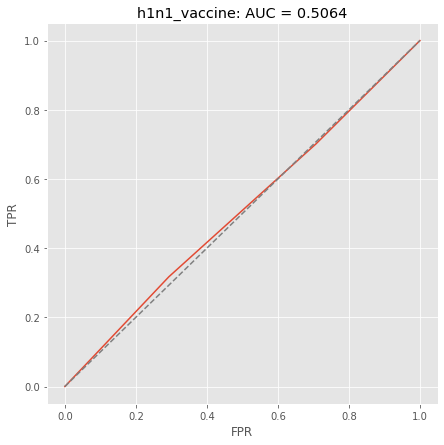

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval, 
    preds[:, 1], 
    'h1n1_vaccine',
    ax=ax
)

### seasonal 

In [39]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
)

In [40]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_eval, y_eval)

0.5578665568369028

In [41]:
preds = knn.predict_proba(X_eval)

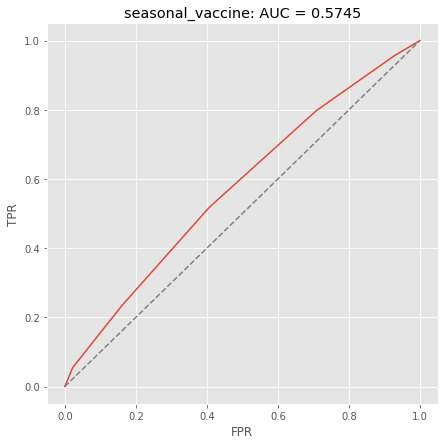

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval, 
    preds[:, 1], 
    'seasonal_vaccine',
    ax=ax
)

KNN is almost no better than a dumb predictor model

# Random Forrest

### h1n1

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
)

In [45]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)
rfc.score(X_eval, y_eval)

0.850494233937397

In [46]:
preds = rfc.predict_proba(X_eval)

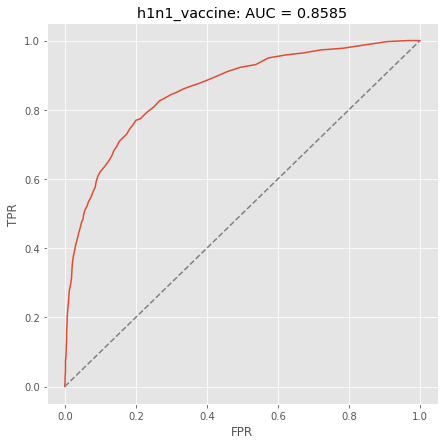

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval, 
    preds[:, 1], 
    'h1n1_vaccine',
    ax=ax
)

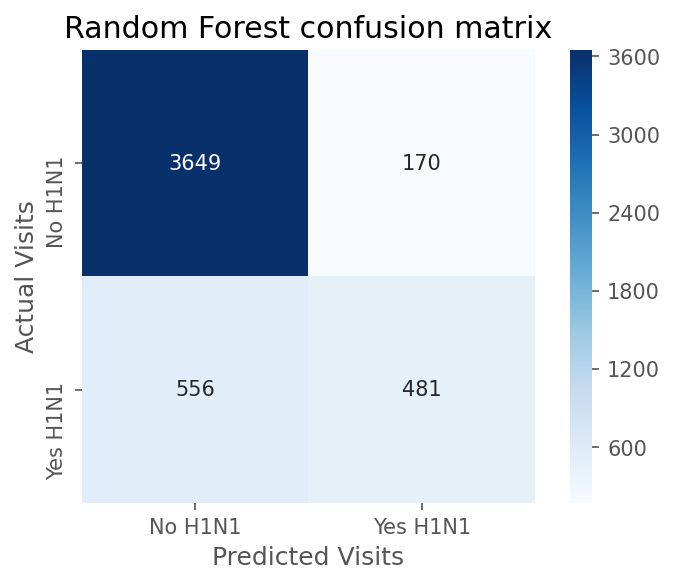

In [48]:
rf_confusion = confusion_matrix(y_eval, rfc.predict(X_eval))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
           xticklabels=['No H1N1', 'Yes H1N1'],
           yticklabels=['No H1N1', 'Yes H1N1'])

plt.xlabel('Predicted Visits')
plt.ylabel('Actual Visits')
plt.title('Random Forest confusion matrix');

In [49]:
print(classification_report(y_eval, rfc.predict(X_eval), target_names=["No H1N1", "Yes H1N1"]))

              precision    recall  f1-score   support

     No H1N1       0.87      0.96      0.91      3819
    Yes H1N1       0.74      0.46      0.57      1037

    accuracy                           0.85      4856
   macro avg       0.80      0.71      0.74      4856
weighted avg       0.84      0.85      0.84      4856



In [50]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
)

In [51]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)
rfc.score(X_eval, y_eval)

0.7722405271828665

In [52]:
preds = rfc.predict_proba(X_eval)

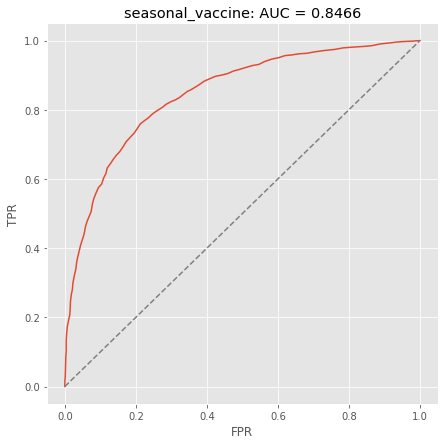

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_roc(
    y_eval, 
    preds[:, 1], 
    'seasonal_vaccine',
    ax=ax
)

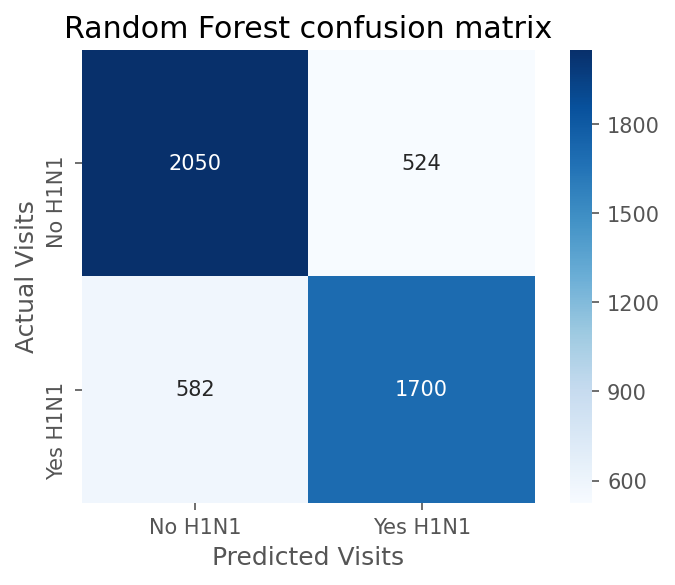

In [54]:
rf_confusion = confusion_matrix(y_eval, rfc.predict(X_eval))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
           xticklabels=['No H1N1', 'Yes H1N1'],
           yticklabels=['No H1N1', 'Yes H1N1'])

plt.xlabel('Predicted Visits')
plt.ylabel('Actual Visits')
plt.title('Random Forest confusion matrix');

Random forest and Log regression are about the same, log regression is a bit better...